# Exercise 5: Wind-effects on a mixed channel

In this exercise we study the effects of wind on a stratified lake. For a stratified lake, wind not only generates a water level set-up, but also causes a tilt of the interface. Furthermore, the vertical profile of the horizontal velocity is affected. Here we investigate these effects and explore the sensitivity for changes in wind speed, density, and layer thicknesses.

The lake is 40 km long, 40 m deep and has a 20 m thick upper layer ($h_1$ = 20 m) of 24 degrees Celsius ($\rho_1$ = 997.3 kg/m$^3$) and a lower layer of 4 degrees Celsius ($\rho_2$ = 999.7 kg/m$^3$).


## 5.1)  Baroclinic tilt and vertical  circulations 

a)	From the horizontal momentum equations for the two layer system, it can be derived that surface tilt $\partial \zeta / \partial x$ and interface tilt $\partial \eta / \partial x$ are related through: 

\begin{equation}
    g' \frac{\partial \eta}{\partial x} = -g \frac{\partial \zeta}{\partial x}
\end{equation}

with 

\begin{equation}
    g' = \frac{\rho_2 - \rho_1}{\rho_1}g
\end{equation}

The surface tilt is related to the wind stress through:

\begin{equation}
    \rho_1 g \frac{\partial \zeta}{\partial x} \approx \frac{\tau_w}{h_1}
\end{equation}

Use these formulas to estimate the surface and interface tilt in the lake for a wind speed of 5.0 m/s.


b)	Set the parameters to simulate this situation with the (3D) model and compare the estimated and computed results.

c)	Investigate the sensitivity of the interface tilt for changes in the temperature, wind speed and depth (/thickness of the layers).

d)	Based on the two layer approach, the interface is expected to touch the water surface at the wind side of the lake for Wedderburn number $W$ < 0.5, with:

\begin{equation}
    W = \frac{g' H_1^2}{C_D U_w^2 L}
\end{equation}

Estimate the wind speed for which this will happen and simulate that situation. Describe what you see.


## 5.2)  Internal flow 

a)	Run the model again with the original settings and a wind of 5.0 m/s. Once a stationary situation is obtained, pause the model, adapt the wind speed to 0.0001 m/s (i.e. practically zero), and continue the simulation. Describe what you see.

b)	At the moment the wind speed is reduced the tilted interface starts to adjust, causing a sloshing motion. Determine the propagation speed of this perturbation.

c)	How does this compare with the propagation speed of a surface perturbation in homogeneous water? To determine the latter, simulate the homogeneous situation by adapting the temperature and layer thicknesses (or compute it using $c = \sqrt{g h}$).


In [1]:
# Imports
import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import time
import os
# Something very fishy happening if I don't define a plot first.
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
import matplotlib.pyplot as plt
import sys
plt.ioff()
_ = plt.figure()
plt.ion()

# Toggle button for hiding the raw code
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import os
basepath = (os.path.abspath(os.path.join(os.getcwd(),"..","..")))
engine = basepath+r"\dflowfm_exe\oss_artifacts_x64_65957\x64\share\bin\dflowfm"
mdufile = basepath+r"\5. Channel\Models\t2.mdu"

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile);
wrapper.initialize();
# wrapper.update()

In [4]:
# for i in range(wrapper.get_var_count()):
#     print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)))

In [5]:
# printx(wrapper.get_var("ndxi"))

In [6]:
# x = wrapper.get_var("xz")
# y = wrapper.get_var("yz")
# zws = wrapper.get_var("zws")
# print(np.shape(zws))
# plt.figure()
# plt.plot(x, y)

In [7]:
maxsteps = 10000
parameters = []
parameters = [
    {
        "parameter": "wx",
        "description": "Wind velocity $[m/s]$",
        "default": 15
    }
]

In [8]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=100,
    min=0,
    max=maxsteps,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

sliceslider = widgets.IntSlider(  
    description="Change position of slice",
    min=0,
    max=1,
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

# parameters = ["zbndz", "zbndq", "frcu"]
# p_descrip = ["Boundary Water level", "Boundary Discharge", "Roughness Chézy"]

items=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [9]:
# parameters[0]["default"]

In [10]:
# Model specific function 
xz = wrapper.get_var('xz')[:] / 100
yz = wrapper.get_var('yz')[:]
indy = np.argsort(yz)[::-1]
newx = xz[indy]
randind = np.random.choice(len(xz), int(len(xz)/5), replace=False)

lX = len(np.unique(xz))
lY = len(np.unique(yz))
newx = newx.reshape((lY, lX))
indx = np.argsort(newx, axis=1)
# print(lX)
Z = int((len(wrapper.get_var('zws')) - lX) / lX)
# print(Z)

Xarr = np.tile(xz, (Z, 1))

#     Automate parameter and grid sizes
def update_data():
    ucx = wrapper.get_var('ucx')[lX:].copy()
    ucy = wrapper.get_var('ucy')[lX:].copy()
    zws = wrapper.get_var('zws')[lX:].copy()
    temp = wrapper.get_var('temperature')[lX:].copy()
#     k = wrapper.get_var('turkin1')[lX:].copy()

    data.append(dict({
        "time": wrapper.get_current_time(),
        "ucx": ucx.reshape((lX, Z)).transpose(), 
        "ucy": ucy.reshape((lX, Z)).transpose(), 
        "zws": zws.reshape((lX, Z)).transpose(), 
        "temp": temp.reshape((lX, Z)).transpose(),
#         "k": k.reshape((lX, Z)).transpose()

    }))
    slider.max = len(data)
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [11]:
# xz[50]

In [12]:
sliceslider.max = lX - 1
sliceslider.value = int(lX/2)

In [13]:
# Standard functions for button widgets
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    settings.disabled = True
    nsteps.disabled = True
    sliceslider.disabled = True
    for i in items:
        i.disabled = True
    start_loop(int(nsteps.value))
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    sliceslider.disabled = False
    nsteps.disabled = False
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v):
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "":
        return
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(parameters[i]['default'])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    slider.value = 0
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


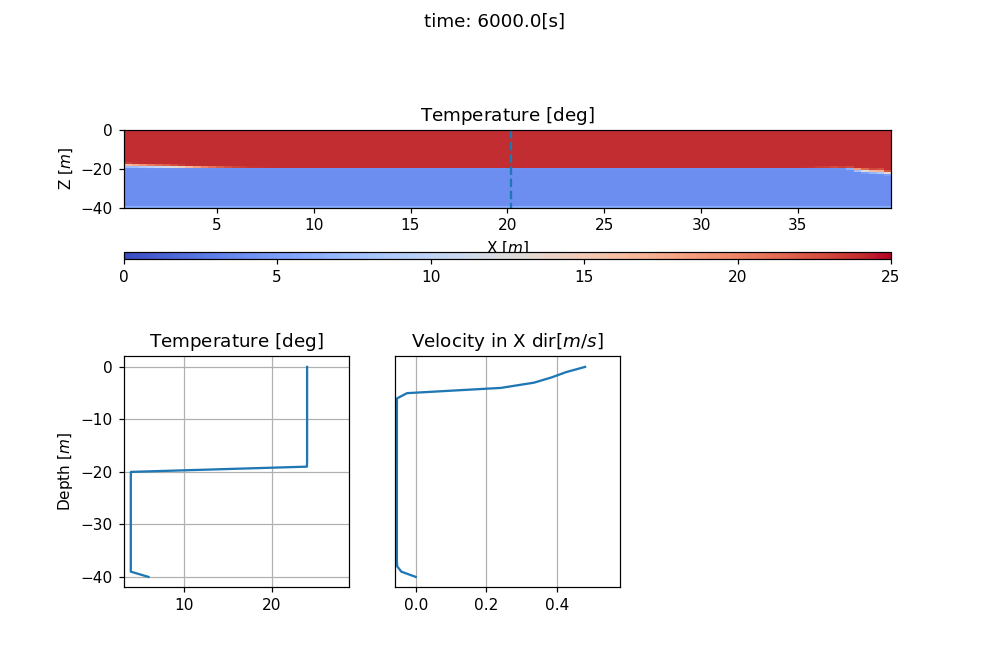

In [14]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 6) # (w, h)

Xslice = 50
# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)
timestep = 0
def set_plot(change):
    t = change['new']
    minT = data[-1]["temp"][:, sliceslider.value].min()
    maxT = data[-1]["temp"][:, sliceslider.value].max()
    minV = data[-1]["ucx"][:, sliceslider.value].min()
    maxV = data[-1]["ucx"][:, sliceslider.value].max()
    ax2.set_xlim([round(minT - 0.2*np.abs(minT), 2), round(maxT + 0.2*np.abs(maxT), 2)])
    ax3.set_xlim([round(minV - 0.2*np.abs(minV), 2), round(maxV + 0.2*np.abs(maxV), 2)])

    temp_line.set_data(data[t]['temp'][:, sliceslider.value], data[t]["zws"][:, sliceslider.value])
    vel_line.set_data(data[t]['ucx'][:, sliceslider.value], data[t]["zws"][:, sliceslider.value])
#     k_line.set_data(data[timestep]['k'][:, sliceslider.value], data[timestep]["zws"][:, sliceslider.value])
    if (t < len(data)):
        temp.set_data(data[t]["temp"])
#         vortscat.set_array(data[t]["magR"])
        t1.set_text("time: " + str(data[t]["time"]) + "[s]")
#         quiver.set_UVC(data[t]["ucx"][randind], data[t]["ucy"][randind])
        fig.canvas.draw()
    timestep = t

def set_line(change):
    sliceline.set_data((xz[-sliceslider.value], xz[-sliceslider.value]), (0, -40))
    minT = data[-1]["temp"][:, sliceslider.value].min()
    maxT = data[-1]["temp"][:, sliceslider.value].max()
    minV = data[-1]["ucx"][:, sliceslider.value].min()
    maxV = data[-1]["ucx"][:, sliceslider.value].max()
    ax2.set_xlim([round(minT - 0.2*np.abs(minT), 2), round(maxT + 0.2*np.abs(maxT), 2)])
    ax3.set_xlim([round(minV - 0.2*np.abs(minV), 2), round(maxV + 0.2*np.abs(maxV), 2)])

    temp_line.set_data(data[timestep]['temp'][:, sliceslider.value], data[timestep]["zws"][:, sliceslider.value])
    vel_line.set_data(data[timestep]['ucx'][:, sliceslider.value], data[timestep]["zws"][:, sliceslider.value])
    fig.canvas.draw()
    
slider.observe(set_plot, 'value')
sliceslider.observe(set_line, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    change_param(i)
    i.observe(change_param, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params]), sliceslider]))
fig = plt.figure()
ax0 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0), rowspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 1), rowspan=1)
# ax4 = plt.subplot2grid((2, 4), (1, 2), rowspan=1)
display(player)

t1 = fig.suptitle("time: " + str(data[0]["time"]) + "[s]")

temp = ax0.imshow(data[0]["temp"], cmap="coolwarm", extent=[xz.min(), xz.max(), 0, -40 ], vmin=0, vmax=25)
ax0.set_xlabel("X $[m]$")
ax0.set_ylabel("Z $[m]$")
# quiver = ax0.quiver(Xarr[::5, ::5], data[0]["zws"][::5, ::5], data[0]["ucx"][::5, ::5], data[0]["ucy"][::5, ::5], angles='xy', scale_units='xy', scale=0.0001)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('bottom', size='10%', pad=0.4)
cbar = plt.colorbar(temp, orientation='horizontal', cax=cax0);
sliceline, = ax0.plot((xz[-sliceslider.value], xz[-sliceslider.value]), (0, -40), "--")
ax0.invert_yaxis()
ax0.invert_xaxis()
ax0.set_xticklabels(np.arange(40, 0, -5))

ax0.set_title('Temperature $[\deg]$')

temp_line, = ax2.plot(data[0]['temp'][:, sliceslider.value], data[0]['zws'][:, sliceslider.value])
ax2.set_title('Temperature $[\deg]$')
ax2.set_ylabel('Depth $[m]$')
ax2.grid()

vel_line, = ax3.plot(data[0]['ucx'][:, sliceslider.value], data[0]['zws'][:, sliceslider.value])
ax3.set_title('Velocity in X dir$[m/s]$')
# k_line, = ax3.plot(data[0]['k'][:, sliceslider.value], data[0]['zws'][:, sliceslider.value])

ax3.yaxis.set_visible(False)
ax3.grid()
# ax4.yaxis.set_visible(False)

plt.draw()

In [15]:
# print([round(data[-1]["temp"][:, sliceslider.value].min(), 2), round(1.2 * data[-1]["temp"][:, sliceslider.value].max(), 2)])
# print([round(0.8 * data[-1]["ucx"][:, sliceslider.value].min(), 2), round(1.2 * data[-1]["ucx"][:, sliceslider.value].max(), 2)])

In [16]:
# plt.figure()
# plt.imshow(data[-1]["temp"], extent=[xz.min(), xz.max(), 0, -40 ], cmap="coolwarm", vmin=0, vmax=25)